In [2]:
import glider.visualize as visualize
import glider.vehicle as vehicle

import mediapy as media

# GliderSIM

This is a genetic algorithm to optimise a glider form.

That means we put a population of gliders through a test and see which perform the best.

The best gliders of that generation have offspring and so we improve the performance over time.


## The Gliders

Gliders are a combination of points and faces that make up a polygon. They look like this:

""

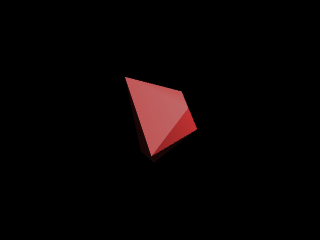

In [3]:
v = vehicle.Vehicle(
    num_vertices=10,
    pilot=False,
    )
media.show_image(visualize.view_vehicle(*v.create_glider_from_vertices()))

## The Test

The test is a drop from 80m.

The glider's score is determined by the distance travelled to the left or right.

In [4]:
import glider.simulation as simulation

test_xml_representation = simulation.drop_test_glider(
    *v.create_glider_from_vertices()
)

visualize.render_xml_to_collision(
    test_xml_representation,
    camera_name="fixed",
    show=True
)

We measure the x-position at the time of collision. 

This defines the `fitness_func`

In [5]:
import glider.optimization as optimization

score = optimization.fitness_func(v)

print(f"Glider Score: {score}")

Glider Score: 8.051444413065695


## Improving the glider shape

The simplest way to get a better glider, is to try different shapes. 

In the cell below, we create a population of gliders, and test each one.

In [6]:
population = [vehicle.Vehicle(num_vertices=10, pilot=False) for _ in range(100)]

fitnesses = [optimization.fitness_func(v) for v in population]

This is what the top performers looked like:

""

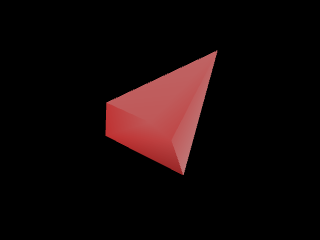

Fitness: 21.313044620205886


""

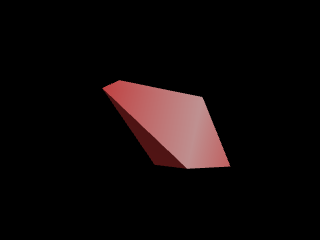

Fitness: 17.455708798474983


""

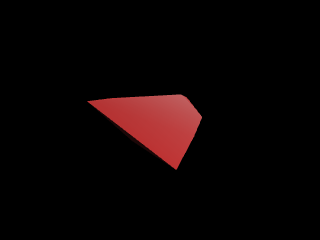

Fitness: 17.428387585746044


In [7]:
ranking = list(zip(population, fitnesses))
ranking.sort(key=lambda x: x[1], reverse=True)  # Sort by highest to lowest fitness

for glider, fitness in ranking[:3]:
    media.show_image(visualize.view_vehicle(*glider.create_glider_from_vertices()))
    print(f"Fitness: {fitness}")

Graphing the distribution of the glider performances, we get:

<Axes: ylabel='Frequency'>

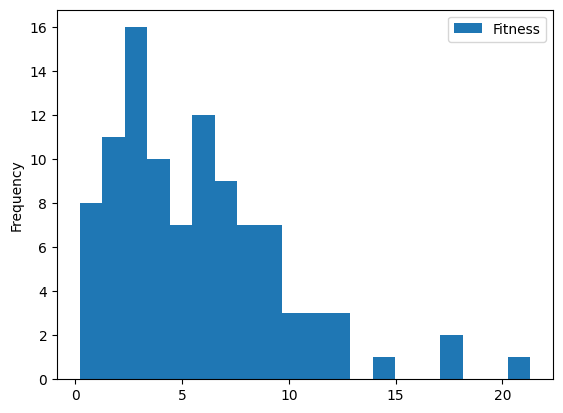

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(ranking, columns=["Vehicle", "Fitness"])
df.plot.hist(bins=20)

And the drop test for the best glider, looked like this:

In [9]:
winning_glider, fitness = ranking[0]

drop_test_xml = simulation.drop_test_glider(*winning_glider.create_glider_from_vertices())

visualize.render_xml_to_collision(
    drop_test_xml,
    camera_name="fixed",
    show=True
)

In [10]:
from io import BytesIO

from glider.optimization import iterate_population, fitness_func
from glider.visualize import view_vehicle

best_glider_frames = []
population_performance_frames = []

population = [vehicle.Vehicle(num_vertices=10, pilot=False) for _ in range(100)] 
for i in range(300):
    ranking, population = iterate_population(
        population=population,
        pilot=False,
        survival_weight = 0.1,
        cloning_weight = 0.3,
    )

    if i % 10 == 0:
        print("Iteration:", i)
        winning_vehicle = population[0]
        print("Fitness:", fitness_func(winning_vehicle))

    best_glider_frames.append(view_vehicle(*winning_vehicle.create_glider_from_vertices()))
    
    df = pd.DataFrame(ranking, columns=["Vehicle", "Fitness"])
    fig = df.plot.hist(bins=20).get_figure()
    fig_io = BytesIO()
    population_performance_frames.append(fig.savefig(fig_io, format='png'))
    population_performance_frames.append(fig_io.getvalue())
    plt.close(fig)


    


Iteration: 0
Fitness: 21.257996321910277
Iteration: 10
Fitness: 46.03666022611204
Iteration: 20
Fitness: 64.17237844255192
Iteration: 30
Fitness: 64.17237844255192
Iteration: 40
Fitness: 64.17237844255192
Iteration: 50
Fitness: 64.17237844255192
Iteration: 60
Fitness: 64.17237844255192
Iteration: 70
Fitness: 64.17237844255192
Iteration: 80
Fitness: 64.17237844255192
Iteration: 90
Fitness: 64.17237844255192
Iteration: 100
Fitness: 70.49600875367975
Iteration: 110
Fitness: 70.49600875367975
Iteration: 120
Fitness: 70.49600875367975
Iteration: 130
Fitness: 70.49600875367975
Iteration: 140
Fitness: 70.49600875367975
Iteration: 150
Fitness: 70.49600875367975
Iteration: 160
Fitness: 70.49600875367975
Iteration: 170
Fitness: 70.49600875367975
Iteration: 180
Fitness: 70.49600875367975
Iteration: 190
Fitness: 70.49600875367975
Iteration: 200
Fitness: 70.49600875367975
Iteration: 210
Fitness: 77.85856376970807
Iteration: 220
Fitness: 77.85856376970807
Iteration: 230
Fitness: 77.85856376970807
It

In [11]:
media.show_video(best_glider_frames, fps=3)

In [12]:
# media.show_video(population_performance_frames, fps=3)

""

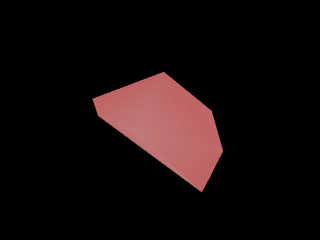

In [13]:
v = population[0]
v.show()

In [14]:
import glider.simulation as sim

test_xml_representation = simulation.drop_test_glider(
    *v.create_glider_from_vertices()
)

visualize.render_xml_to_collision(
    test_xml_representation,
    camera_name="fixed",
    show=True
)

In [15]:
print(test_xml_representation)


<mujoco>
    <option density="1.2" viscosity="2e-05" wind="0 0 0"/>
    <worldbody>
        <light name="top" pos="0 0 5"/>
        <camera name="fixed" pos="0 -100 100" euler="40 0 0"/>
        <!-- Body -->
        
    <body name="body" pos="0 0 0" euler="0 0 0">
        <freejoint/>
        <!-- Main Wing -->
        <geom name="vehicle-wing" density="0.4" pos="-3.0 -3.0 -3.0" rgba="0.8 0.2 0.2 0.5" type="mesh" mesh="vehicle-wing-mesh"/>
        <camera name="track" pos="0 0 0" xyaxes="1 2 0 0 1 2" mode="track"/>
        
    </body>
    
        <!-- Landing Platform -->
        <body name="platform" pos="0 0 0">
            <geom name="platform-geom" type="box" size="1500 1500 1" rgba="1 1 1 1" pos="0 0 -80"/>
        </body>
    </worldbody>

    
            <asset>
                <mesh name="vehicle-wing-mesh" vertex="3.4575835089784275 4.387297806788743 1.843057534499998 2.1769003874860933 2.2915400997682625 2.043454296179107 4.564639225742635 2.109802924602818 1.5093730933